In [17]:
import numpy as np
import pandas as pd 
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import random
import torch.nn.functional as F

In [18]:
class dataset(Dataset):
    def __init__(self, root_dir,transform=None):
        self.root_dir = root_dir
        self.files = [f for f in os.listdir(root_dir) if f.endswith('.npy')]
        self.transform=transform
    def __len__(self):
        return len(self.files)
    def __getitem__(self, idx):
        file_path = os.path.join(self.root_dir, self.files[idx])
        data = np.load(file_path)
        data = torch.tensor(data, dtype=torch.float32)
        if self.transform:
            img = self.transform(img)
        return data

In [19]:
dataset=dataset("/kaggle/input/diffusion/Samples")

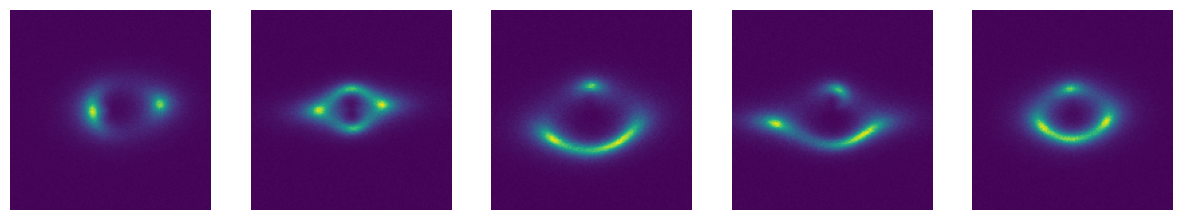

In [20]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for ax in axes:
    idx = random.randint(0, len(dataset) - 1)  
    ax.imshow(dataset[idx].squeeze(0))  
    ax.axis("off")  

plt.show()

In [21]:
torch.cuda.empty_cache()

In [22]:
dataloader=DataLoader(dataset,batch_size=16,shuffle=True)

# Diffusion model(ddpm) with Cosine noise schedule

In [23]:
def cosine_noise_schedule(timesteps, s=0.008, device='cuda'): 
    steps = torch.linspace(0, timesteps, timesteps + 1, device=device)
    f_t = torch.cos((steps / timesteps + s) / (1 + s) * (np.pi / 2)) ** 2
    beta = torch.clip(1 - (f_t[1:] / f_t[:-1]), 0.0001, 0.9999)
    alpha = 1 - beta
    alpha_bar = torch.cumprod(alpha, dim=0)
    return beta, alpha, alpha_bar

class UNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim=64, downsample=False, upsample=False):
        super().__init__()
        
        self.time_mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, out_channels),
            nn.SiLU()
        )
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.GroupNorm(8, out_channels),  
            nn.SiLU()
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.GroupNorm(8, out_channels),
            nn.SiLU()
        )
        
        self.res_conv = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
        
        self.downsample = downsample
        self.upsample = upsample
        
        if downsample:
            self.down = nn.Conv2d(out_channels, out_channels, 4, stride=2, padding=1)
        if upsample:
            self.up = nn.ConvTranspose2d(out_channels, out_channels, 4, stride=2, padding=1)
    
    def forward(self, x, t):
        time_emb = self.time_mlp(t)
        time_emb = time_emb.unsqueeze(-1).unsqueeze(-1)
        
        # Main path
        h = self.conv1(x)
        h = h + time_emb
        h = self.conv2(h)
        
        out = h + self.res_conv(x)
        
        if self.downsample:
            return self.down(out)
        elif self.upsample:
            return self.up(out)
        else:
            return out

class DiffusionUNet(nn.Module):
    def __init__(self, in_channels=1, base_channels=64, time_emb_dim=64, timesteps=1000):
        super().__init__()
        
        self.time_embed = nn.Sequential(
            nn.Embedding(timesteps, time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim)
        )
        
        self.conv_in = nn.Conv2d(in_channels, base_channels, kernel_size=3, padding=1)
        
        self.down1 = UNetBlock(base_channels, base_channels, time_emb_dim)
        self.down2 = UNetBlock(base_channels, base_channels, time_emb_dim, downsample=True)
        self.down3 = UNetBlock(base_channels, base_channels*2, time_emb_dim)
        self.down4 = UNetBlock(base_channels*2, base_channels*2, time_emb_dim, downsample=True)
        self.down5 = UNetBlock(base_channels*2, base_channels*4, time_emb_dim)
        
        self.middle1 = UNetBlock(base_channels*4, base_channels*4, time_emb_dim)
        self.middle_attn = nn.Sequential(
            nn.GroupNorm(8, base_channels*4),
            nn.Conv2d(base_channels*4, base_channels*4, 1),
            nn.SiLU()
        )
        self.middle2 = UNetBlock(base_channels*4, base_channels*4, time_emb_dim)
        
        self.up1 = UNetBlock(base_channels*4, base_channels*2, time_emb_dim)
        self.up2 = UNetBlock(base_channels*2, base_channels*2, time_emb_dim, upsample=True)
        self.up3 = UNetBlock(base_channels*2, base_channels, time_emb_dim)
        self.up4 = UNetBlock(base_channels, base_channels, time_emb_dim, upsample=True)
        self.up5 = UNetBlock(base_channels, base_channels, time_emb_dim)
        
        self.conv_out = nn.Sequential(
            nn.GroupNorm(8, base_channels),
            nn.SiLU(),
            nn.Conv2d(base_channels, in_channels, kernel_size=3, padding=1)
        )
    
    def forward(self, x, timestep):
        t = self.time_embed(timestep)
        x = self.conv_in(x)        
        d1 = self.down1(x, t)
        d2 = self.down2(d1, t)
        d3 = self.down3(d2, t)
        d4 = self.down4(d3, t)
        d5 = self.down5(d4, t)        
        m = self.middle1(d5, t)
        m = m + self.middle_attn(m)  
        m = self.middle2(m, t)        
        u1 = self.up1(m, t)
        u2 = self.up2(u1, t)
        d3 = d3[:, :, :u2.shape[2], :u2.shape[3]]
        u2 = u2 + d3
        u3 = self.up3(u2, t)
        u4 = self.up4(u3, t)
        u4 = F.interpolate(u4, size=(d1.shape[2], d1.shape[3]), mode='bilinear', align_corners=False)
        u4 = u4 + d1 
        u5 = self.up5(u4, t)
        
        return self.conv_out(u5)

class GravitationalLensingDiffusion:
    def __init__(self, timesteps=1000, image_size=150):
        self.timesteps = timesteps
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        self.betas, self.alphas, self.alpha_bar = cosine_noise_schedule(
            timesteps, 
            device=self.device
        )
        self.model = DiffusionUNet(timesteps=timesteps).to(self.device)
        
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=2e-4, weight_decay=1e-5)
        self.scheduler = CosineAnnealingLR(self.optimizer, T_max=100, eta_min=2e-5)
        
    def q_sample(self, x0, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x0)        
        t = t.to(self.device)
        
        sqrt_alpha_bar_t = torch.sqrt(self.alpha_bar[t]).reshape(-1, 1, 1, 1)
        sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - self.alpha_bar[t]).reshape(-1, 1, 1, 1)
        
        return sqrt_alpha_bar_t * x0 + sqrt_one_minus_alpha_bar_t * noise
    
    def train_step(self, batch):
        self.optimizer.zero_grad()
        
        batch_size = batch.shape[0]
        t = torch.randint(0, self.timesteps, (batch_size,), device=self.device)
        
        noise = torch.randn_like(batch)
        noisy_imgs = self.q_sample(batch, t, noise)        
        noise_pred = self.model(noisy_imgs, t)
        
        loss = nn.functional.mse_loss(noise_pred, noise)
        loss.backward()        
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
        
        self.optimizer.step()
        return loss.item()
    
    def sample(self, num_samples=1, size=(1, 150, 150)):
        with torch.no_grad():  
            x = torch.randn(num_samples, *size, device=self.device)
            
            sample_steps = min(100, self.timesteps)
            skip = self.timesteps // sample_steps
            
            for i in reversed(range(0, self.timesteps, skip)):
                t_batch = torch.full((num_samples,), i, device=self.device)                
                noise_pred = self.model(x, t_batch)                
                alpha = self.alphas[i]
                alpha_bar = self.alpha_bar[i]
                alpha_bar_prev = self.alpha_bar[i-skip] if i-skip >= 0 else torch.tensor(1.0).to(self.device)                
                sqrt_alpha_bar = torch.sqrt(alpha_bar)
                sqrt_1m_alpha_bar = torch.sqrt(1 - alpha_bar)
                sqrt_1m_alpha_bar_prev = torch.sqrt(1 - alpha_bar_prev)                
                pred_x0 = (x - sqrt_1m_alpha_bar * noise_pred) / sqrt_alpha_bar                
                direction = torch.sqrt(1 - alpha_bar_prev) * noise_pred
                x = torch.sqrt(alpha_bar_prev) * pred_x0 + direction
            
            return x
    def train(self, dataloader, epochs=10):
        for epoch in range(epochs):
            total_loss = 0
            for batch_idx, batch in enumerate(tqdm(dataloader)):
                batch = batch.to(self.device)
                loss = self.train_step(batch)
                total_loss += loss                               
            self.scheduler.step()
            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataloader)}")
    def evaluate_samples(self, real_samples, generated_samples):
        real_mean = torch.mean(real_samples, dim=0)
        gen_mean = torch.mean(generated_samples, dim=0)  
        real_cov = torch.cov(real_samples.view(real_samples.size(0), -1).T)
        gen_cov = torch.cov(generated_samples.view(generated_samples.size(0), -1).T)        
        mean_diff = torch.norm(real_mean - gen_mean)
        cov_diff = torch.norm(real_cov - gen_cov)
        return mean_diff + cov_diff

In [24]:
diffusion_model = GravitationalLensingDiffusion()    

In [25]:
diffusion_model.train(dataloader, epochs=30)

100%|██████████| 625/625 [02:55<00:00,  3.55it/s]


Epoch 1/30, Loss: 0.014719757232442498


100%|██████████| 625/625 [02:35<00:00,  4.02it/s]


Epoch 2/30, Loss: 0.004744442928954959


100%|██████████| 625/625 [02:32<00:00,  4.09it/s]


Epoch 3/30, Loss: 0.004152651760168374


100%|██████████| 625/625 [02:31<00:00,  4.13it/s]


Epoch 4/30, Loss: 0.003846398779563606


100%|██████████| 625/625 [02:27<00:00,  4.23it/s]


Epoch 5/30, Loss: 0.003961033528484404


100%|██████████| 625/625 [02:30<00:00,  4.15it/s]


Epoch 6/30, Loss: 0.0037379680027253928


100%|██████████| 625/625 [02:24<00:00,  4.31it/s]


Epoch 7/30, Loss: 0.003848512668441981


100%|██████████| 625/625 [02:26<00:00,  4.26it/s]


Epoch 8/30, Loss: 0.003648039058689028


100%|██████████| 625/625 [02:23<00:00,  4.35it/s]


Epoch 9/30, Loss: 0.0033578140267170966


100%|██████████| 625/625 [02:34<00:00,  4.04it/s]


Epoch 10/30, Loss: 0.003525633405148983


100%|██████████| 625/625 [02:45<00:00,  3.77it/s]


Epoch 11/30, Loss: 0.0037671182397753


100%|██████████| 625/625 [02:32<00:00,  4.09it/s]


Epoch 12/30, Loss: 0.003721442253421992


100%|██████████| 625/625 [02:23<00:00,  4.36it/s]


Epoch 13/30, Loss: 0.003253684079833329


100%|██████████| 625/625 [02:24<00:00,  4.34it/s]


Epoch 14/30, Loss: 0.003352368711959571


100%|██████████| 625/625 [02:43<00:00,  3.83it/s]


Epoch 15/30, Loss: 0.0034614000083878636


100%|██████████| 625/625 [02:41<00:00,  3.87it/s]


Epoch 16/30, Loss: 0.0038165936714969575


100%|██████████| 625/625 [02:42<00:00,  3.85it/s]


Epoch 17/30, Loss: 0.003436073544342071


100%|██████████| 625/625 [02:32<00:00,  4.10it/s]


Epoch 18/30, Loss: 0.0032667462735902516


100%|██████████| 625/625 [02:25<00:00,  4.28it/s]


Epoch 19/30, Loss: 0.003268297388125211


100%|██████████| 625/625 [02:23<00:00,  4.37it/s]


Epoch 20/30, Loss: 0.003425049467291683


100%|██████████| 625/625 [02:22<00:00,  4.38it/s]


Epoch 21/30, Loss: 0.0036036741665098817


100%|██████████| 625/625 [02:23<00:00,  4.37it/s]


Epoch 22/30, Loss: 0.0029259658102411775


100%|██████████| 625/625 [02:23<00:00,  4.36it/s]


Epoch 23/30, Loss: 0.0034063953740522267


100%|██████████| 625/625 [02:26<00:00,  4.26it/s]


Epoch 24/30, Loss: 0.0032882151935249566


100%|██████████| 625/625 [02:26<00:00,  4.28it/s]


Epoch 25/30, Loss: 0.0030122746179811655


100%|██████████| 625/625 [02:24<00:00,  4.32it/s]


Epoch 26/30, Loss: 0.00360474442509003


100%|██████████| 625/625 [02:33<00:00,  4.07it/s]


Epoch 27/30, Loss: 0.0031452988619916143


100%|██████████| 625/625 [02:26<00:00,  4.25it/s]


Epoch 28/30, Loss: 0.0031367920334450902


100%|██████████| 625/625 [02:29<00:00,  4.18it/s]


Epoch 29/30, Loss: 0.0030754936875309795


100%|██████████| 625/625 [02:22<00:00,  4.38it/s]

Epoch 30/30, Loss: 0.003060888810409233


In [29]:
torch.save(diffusion_model.model.state_dict(), "model.pth")

FID-like Score: 99.57647705078125


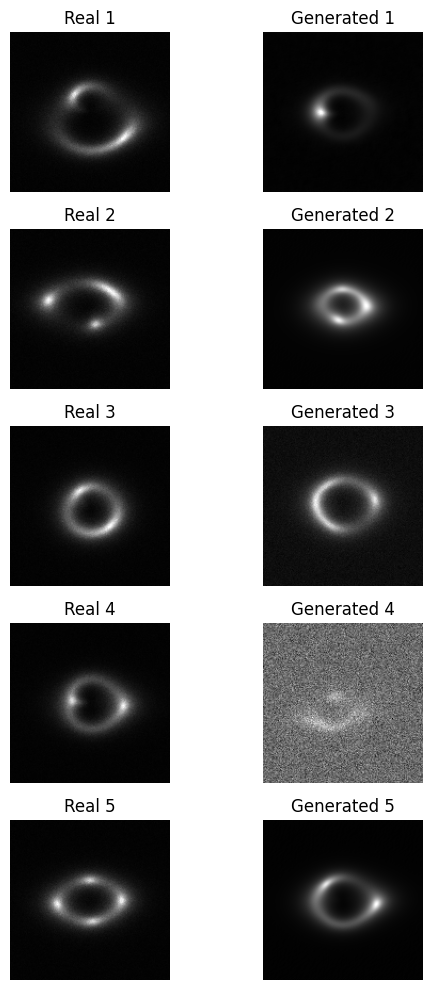

In [30]:
import matplotlib.pyplot as plt
real_samples = next(iter(dataloader)).to(diffusion_model.device)
generated_samples = diffusion_model.sample(num_samples=len(real_samples))

fid_score = diffusion_model.evaluate_samples(real_samples, generated_samples)
print(f"FID-like Score: {fid_score}")

num_display = 5

fig, axes = plt.subplots(num_display, 2, figsize=(6, num_display * 2))

for i in range(num_display):
    axes[i, 0].imshow(real_samples[i].cpu().squeeze(), cmap='gray')
    axes[i, 0].set_title(f"Real {i+1}")
    axes[i, 0].axis("off")
    
    axes[i, 1].imshow(generated_samples[i].cpu().squeeze(), cmap='gray')
    axes[i, 1].set_title(f"Generated {i+1}")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()
